In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns

In [2]:
# Load the CSV file into a DataFrame
file_path = 'programmatic_publisher.csv'  # Update with your file's correct path
df_programmatic_publisher = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify
display(df_programmatic_publisher.head(10))

,dsp_id,timestamp_utc,campaign_name,device_type,cost_milli_cent
0,dsp9tnGII5BeXbn6LUSFZPcKGCyI0F,2024-02-06 04:10:41,Contextual,Phone,283.496
1,dsp1hXcI9Q6TZYzLEmeTkxzhjqD6HJ,2024-02-26 23:49:23,Retargeting,PC,1884.537
2,dspcd3UcXUcUk0PEo2hb8CEH3WVlFE,2024-06-16 20:55:27,Contextual,TV,601.930
3,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-06-26 19:15:54,Contextual,TV,1191.750
4,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-05-31 18:38:54,Retargeting,TV,739.262
5,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-06-05 22:50:03,Retargeting,PC,153.500
6,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-09 21:06:22,Contextual,TV,5878.010
7,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-15 21:41:44,Contextual,TV,3073.631
8,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-16 20:47:06,Contextual,TV,3161.905
9,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-16 21:56:50,Contextual,TV,2582.035


In [4]:
print(len(df_programmatic_publisher))

17493428


In [5]:
print(df_programmatic_publisher.dtypes)

dsp_id              object
timestamp_utc       object
campaign_name       object
device_type         object
cost_milli_cent    float64
dtype: object


In [7]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    return missing_summary

summary = count_missing_values_summary(df_programmatic_publisher)
print(summary)

                 Missing Count  Missing Percentage (%)
dsp_id                       0                     0.0
timestamp_utc                0                     0.0
campaign_name                0                     0.0
device_type                  0                     0.0
cost_milli_cent              0                     0.0


### Data Type - Datetime

In [8]:
df_programmatic_publisher_cleaned = df_programmatic_publisher

In [9]:
# Convert 'timestamp_utc' to datetime
df_programmatic_publisher_cleaned['timestamp_utc'] = pd.to_datetime(df_programmatic_publisher_cleaned['timestamp_utc'])

# Verify the new data type
print(df_programmatic_publisher_cleaned['timestamp_utc'].dtypes)

datetime64[ns]


In [10]:
df_programmatic_publisher_cleaned['year'] = df_programmatic_publisher_cleaned['timestamp_utc'].dt.year
df_programmatic_publisher_cleaned['month'] = df_programmatic_publisher_cleaned['timestamp_utc'].dt.month
df_programmatic_publisher_cleaned['day'] = df_programmatic_publisher_cleaned['timestamp_utc'].dt.day
df_programmatic_publisher_cleaned['day_of_week'] = df_programmatic_publisher_cleaned['timestamp_utc'].dt.dayofweek
df_programmatic_publisher_cleaned['quarter'] = df_programmatic_publisher_cleaned['timestamp_utc'].dt.quarter

In [11]:
# Group by day and count unique dsp_ids
timestamp_counts = df_programmatic_publisher_cleaned.groupby(df_programmatic_publisher_cleaned['timestamp_utc'].dt.date)['dsp_id'].count()

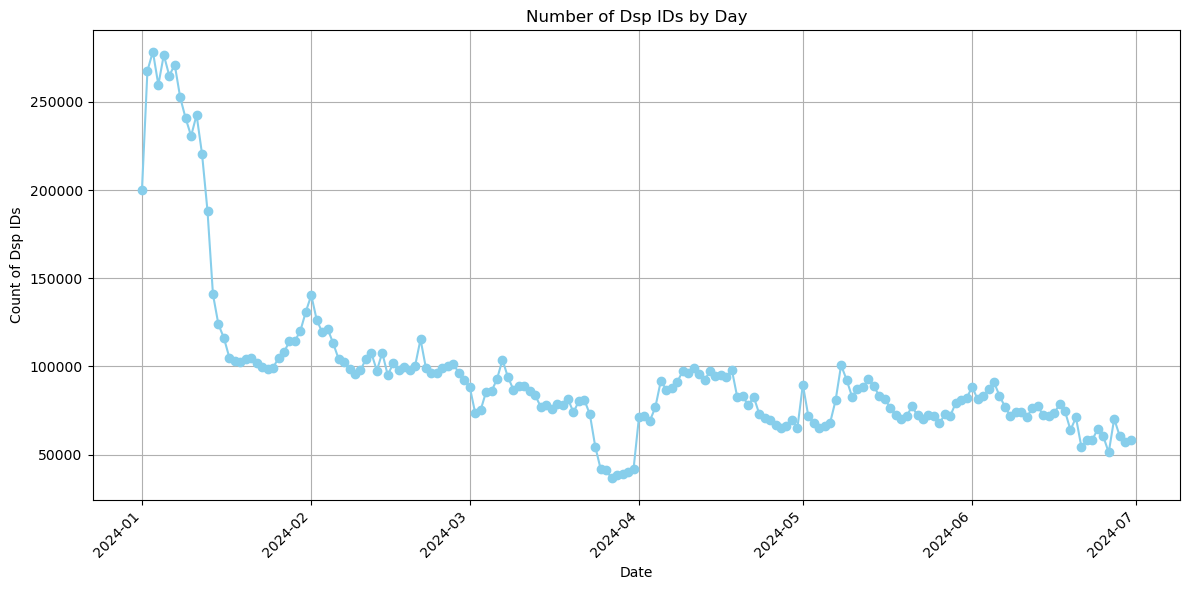

In [12]:
# Plot customer counts by day
plt.figure(figsize=(12, 6))
timestamp_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Number of Dsp IDs by Day')
plt.xlabel('Date')
plt.ylabel('Count of Dsp IDs')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

### Analyse 'cost_milli_cent' column

In [13]:
# Aggregate costs by day (you can adjust to hourly or other timeframes)
costs_over_time = df_programmatic_publisher_cleaned.groupby(df_programmatic_publisher_cleaned['timestamp_utc'].dt.date)['cost_milli_cent'].sum()

# Convert millicents to cents for better readability
costs_over_time = costs_over_time / 1000

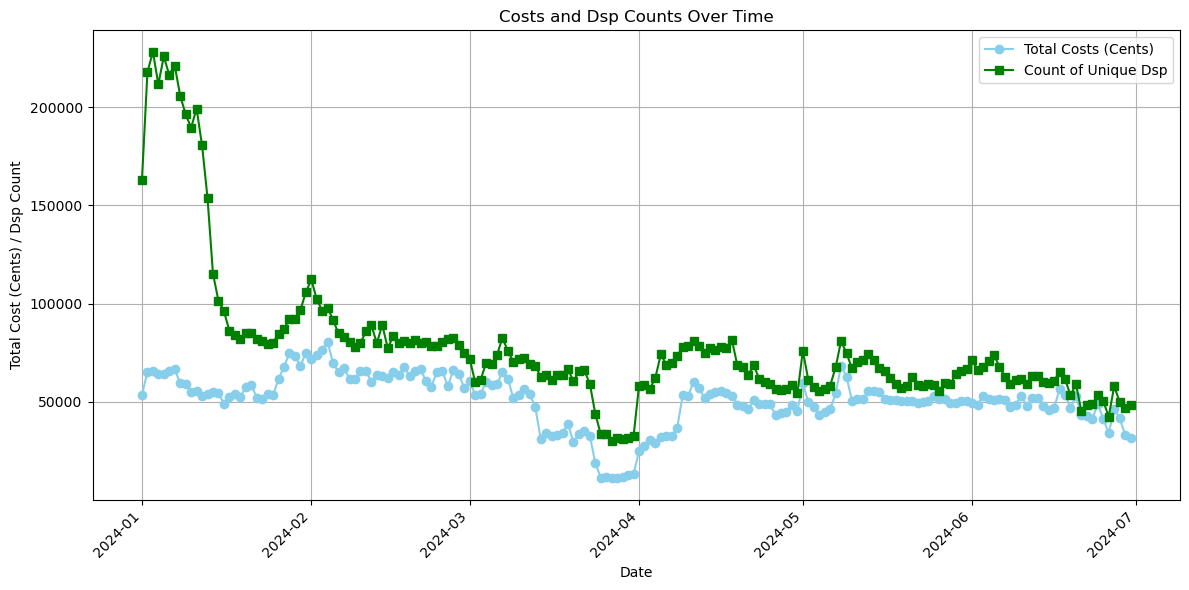

In [14]:
# Aggregate data: Count of dsp per day
device_counts_over_time = df_programmatic_publisher_cleaned.groupby(df_programmatic_publisher_cleaned['timestamp_utc'].dt.date)['dsp_id'].nunique()

# Aggregate costs over time
costs_over_time = df_programmatic_publisher_cleaned.groupby(df_programmatic_publisher_cleaned['timestamp_utc'].dt.date)['cost_milli_cent'].sum() / 1000  # Convert to cents

# Plot costs and dsp counts over time
plt.figure(figsize=(12, 6))

# Plot costs over time
plt.plot(costs_over_time.index, costs_over_time.values, marker='o', color='skyblue', label='Total Costs (Cents)')

# Plot device counts over time
plt.plot(device_counts_over_time.index, device_counts_over_time.values, marker='s', color='green', label='Count of Unique Dsp')

# Add title and labels
plt.title('Costs and Dsp Counts Over Time')
plt.xlabel('Date')
plt.ylabel('Total Cost (Cents) / Dsp Count')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
dsp_costs = df_programmatic_publisher_cleaned.groupby(['dsp_id', df_programmatic_publisher_cleaned['timestamp_utc'].dt.date])['cost_milli_cent'].sum() / 1000
print(dsp_costs.head())

dsp_id                          timestamp_utc
dsp0000zgOGRGzNXlFGuswTD8LV6xA  2024-01-15       0.911876
dsp00040djIAqe73TjNJ1CFKw0K4eu  2024-05-05       4.332313
dsp0006CxEoblczDFJSqDw5BiCtNi6  2024-06-23       0.339680
dsp0006ipUFLA8MoTsAx83XZ11T5hl  2024-06-26       0.144470
dsp0008hWrKfZuquMQaJQrp8FQyKK6  2024-01-31       0.281878
Name: cost_milli_cent, dtype: float64


In [15]:
# Count occurrences of each unique cost and normalize to percentages
cost_counts = df_programmatic_publisher_cleaned['cost_milli_cent'].value_counts(normalize=True) * 100

# Print the percentage values
print("Percentage of each unique cost_milli_cent value:")
print(cost_counts)

Percentage of each unique cost_milli_cent value:
cost_milli_cent
1404.000    0.704905
153.500     0.675722
180.250     0.629305
191.888     0.457052
185.943     0.323401
              ...   
2381.441    0.000006
1116.311    0.000006
1082.543    0.000006
1927.100    0.000006
1589.538    0.000006
Name: proportion, Length: 1932045, dtype: float64


In [20]:
display(df_programmatic_publisher_cleaned.head(10))

,dsp_id,timestamp_utc,campaign_name,device_type,cost_milli_cent,year,month,day,day_of_week,quarter
0,dsp9tnGII5BeXbn6LUSFZPcKGCyI0F,2024-02-06 04:10:41,Contextual,Phone,283.496,2024,2,6,1,1
1,dsp1hXcI9Q6TZYzLEmeTkxzhjqD6HJ,2024-02-26 23:49:23,Retargeting,PC,1884.537,2024,2,26,0,1
2,dspcd3UcXUcUk0PEo2hb8CEH3WVlFE,2024-06-16 20:55:27,Contextual,TV,601.930,2024,6,16,6,2
3,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-06-26 19:15:54,Contextual,TV,1191.750,2024,6,26,2,2
4,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-05-31 18:38:54,Retargeting,TV,739.262,2024,5,31,4,2
5,dspSnORtuQRLSkZKp9nbSIpbJBQLP1,2024-06-05 22:50:03,Retargeting,PC,153.500,2024,6,5,2,2
6,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-09 21:06:22,Contextual,TV,5878.010,2024,5,9,3,2
7,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-15 21:41:44,Contextual,TV,3073.631,2024,5,15,2,2
8,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-16 20:47:06,Contextual,TV,3161.905,2024,5,16,3,2
9,dspfp8NFN8MfPTM5zvmeSJYqX9NzSW,2024-05-16 21:56:50,Contextual,TV,2582.035,2024,5,16,3,2


In [21]:
df_programmatic_publisher_cleaned.shape

(17493428, 10)